In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
# This is done so that the notebook can see files
# placed in a different folder
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from environment.Environment import Env2048

import reverb

from tf_agents.environments import utils
from tf_agents.environments import wrappers
from tf_agents.environments import tf_py_environment
from tf_agents.networks import sequential
from tf_agents.agents.dqn import dqn_agent
from tf_agents.specs import tensor_spec
from tf_agents.utils import common

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import py_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import sequential
from tf_agents.policies import py_tf_eager_policy
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils
from tf_agents.trajectories import trajectory
from tf_agents.specs import tensor_spec
from tf_agents.utils import common

import tensorflow as tf
import numpy as np

In [2]:
num_iterations = 20000 # @param {type:"integer"}

initial_collect_steps = 100  # @param {type:"integer"}
collect_steps_per_iteration =   1# @param {type:"integer"}
replay_buffer_max_length = 100000  # @param {type:"integer"}

batch_size = 64  # @param {type:"integer"}
learning_rate = 1e-3  # @param {type:"number"}
log_interval = 200  # @param {type:"integer"}

num_eval_episodes = 10  # @param {type:"integer"}
eval_interval = 1000  # @param {type:"integer"}

In [3]:
train_py_env = Env2048()
eval_py_env = Env2048()
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

In [13]:
fc_layer_params = (100, 50)
action_tensor_spec = tensor_spec.from_spec(train_env.action_spec())
num_actions = action_tensor_spec.maximum - action_tensor_spec.minimum + 1

# Define a helper function to create Dense layers configured with the right
# activation and kernel initializer.
def dense_layer(num_units):
  return tf.keras.layers.Dense(
      num_units,
      activation=tf.keras.activations.relu,
      kernel_initializer=tf.keras.initializers.VarianceScaling(
          scale=2.0, mode='fan_in', distribution='truncated_normal'))

# QNetwork consists of a sequence of Dense layers followed by a dense layer
# with `num_actions` units to generate one q_value per available action as
# its output.
dense_layers = [dense_layer(num_units) for num_units in fc_layer_params]
q_values_layer = tf.keras.layers.Dense(
    num_actions,
    activation=None,
    kernel_initializer=tf.keras.initializers.RandomUniform(
        minval=-0.03, maxval=0.03),
    bias_initializer=tf.keras.initializers.Constant(-0.2))
q_net = sequential.Sequential(dense_layers + [q_values_layer])

In [14]:
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    time_step_spec = train_env.time_step_spec(),
    action_spec = train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

agent.initialize()

In [15]:
eval_policy = agent.policy
collect_policy = agent.collect_policy

random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

In [17]:
# example_environment = tf_py_environment.TFPyEnvironment(
#     suite_gym.load('CartPole-v0'))

# time_step = example_environment.reset()

# random_policy.action(time_step)

In [34]:
def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0
  for i in range(num_episodes):
    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
        action_step = policy.action(time_step)
        time_step = environment.step(action_step.action)
        episode_return += time_step.reward

    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]

compute_avg_return(eval_env, random_policy, num_eval_episodes)

170.8

## Replay Buffer

In order to keep track of the data collected from the environment, we will use [Reverb](https://deepmind.com/research/open-source/Reverb), an efficient, extensible, and easy-to-use replay system by Deepmind. It stores experience data when we collect trajectories and is consumed during training.

This replay buffer is constructed using specs describing the tensors that are to be stored, which can be obtained from the agent using agent.collect_data_spec.

In [21]:
table_name = 'uniform_table'
replay_buffer_signature = tensor_spec.from_spec(
      agent.collect_data_spec)
replay_buffer_signature = tensor_spec.add_outer_dim(
    replay_buffer_signature)

table = reverb.Table(
    table_name,
    max_size=replay_buffer_max_length,
    sampler=reverb.selectors.Uniform(),
    remover=reverb.selectors.Fifo(),
    rate_limiter=reverb.rate_limiters.MinSize(1),
    signature=replay_buffer_signature)

reverb_server = reverb.Server([table])

replay_buffer = reverb_replay_buffer.ReverbReplayBuffer(
    agent.collect_data_spec,
    table_name=table_name,
    sequence_length=2,
    local_server=reverb_server)

rb_observer = reverb_utils.ReverbAddTrajectoryObserver(
  replay_buffer.py_client,
  table_name,
  sequence_length=2)

## Data Collection

Now execute the random policy in the environment for a few steps, recording the data in the replay buffer.

Here we are using 'PyDriver' to run the experience collecting loop. You can learn more about TF Agents driver in our [drivers tutorial](https://www.tensorflow.org/agents/tutorials/4_drivers_tutorial).

In [22]:
#@test {"skip": true}
py_driver.PyDriver(
    env,
    py_tf_eager_policy.PyTFEagerPolicy(
      random_policy, use_tf_function=True),
    [rb_observer],
    max_steps=initial_collect_steps).run(train_py_env.reset())

NameError: name 'env' is not defined

The agent needs access to the replay buffer. This is provided by creating an iterable `tf.data.Dataset` pipeline which will feed data to the agent.

Each row of the replay buffer only stores a single observation step. But since the DQN Agent needs both the current and next observation to compute the loss, the dataset pipeline will sample two adjacent rows for each item in the batch (`num_steps=2`).

This dataset is also optimized by running parallel calls and prefetching data.

In [40]:
# Dataset generates trajectories with shape [Bx2x...]
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3,
    sample_batch_size=batch_size,
    num_steps=2).prefetch(3)

iterator = iter(dataset)

dataset

<PrefetchDataset element_spec=(Trajectory(
{'action': TensorSpec(shape=(64, 2), dtype=tf.int32, name=None),
 'discount': TensorSpec(shape=(64, 2), dtype=tf.float32, name=None),
 'next_step_type': TensorSpec(shape=(64, 2), dtype=tf.int32, name=None),
 'observation': TensorSpec(shape=(64, 2, 16), dtype=tf.int32, name=None),
 'policy_info': (),
 'reward': TensorSpec(shape=(64, 2), dtype=tf.float32, name=None),
 'step_type': TensorSpec(shape=(64, 2), dtype=tf.int32, name=None)}), SampleInfo(key=TensorSpec(shape=(64, 2), dtype=tf.uint64, name=None), probability=TensorSpec(shape=(64, 2), dtype=tf.float64, name=None), table_size=TensorSpec(shape=(64, 2), dtype=tf.int64, name=None), priority=TensorSpec(shape=(64, 2), dtype=tf.float64, name=None), times_sampled=TensorSpec(shape=(64, 2), dtype=tf.int32, name=None)))>

## Training the agent

Two things must happen during the training loop:

-   collect data from the environment
-   use that data to train the agent's neural network(s)

This example also periodicially evaluates the policy and prints the current score.

The following will take ~5 minutes to run.

In [41]:
#@test {"skip": true}
try:
  %%time
except:
  pass

# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step.
agent.train_step_counter.assign(0)


# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]

# Reset the environment.
time_step = train_py_env.reset()

# Create a driver to collect experience.
collect_driver = py_driver.PyDriver(
    #TODO: Ce env bagi aici?
    train_env,
    py_tf_eager_policy.PyTFEagerPolicy(
      agent.collect_policy, use_tf_function=True),
    [rb_observer],
    max_steps=collect_steps_per_iteration)

for i in range(num_iterations):
    
    print(i)
    # Collect a few steps and save to the replay buffer.
    time_step, _ = collect_driver.run(time_step)

    # Sample a batch of data from the buffer and update the agent's network.
    experience, unused_info = next(iterator)
    train_loss = agent.train(experience).loss

    step = agent.train_step_counter.numpy()

    if step % log_interval == 0:
        print('step = {0}: loss = {1}'.format(step, train_loss))

    if step % eval_interval == 0:
        avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
        print('step = {0}: Average Return = {1}'.format(step, avg_return))
        returns.append(avg_return)

0


InvalidArgumentError: Received incompatible tensor at flattened index 3 from table 'uniform_table'.  Specification has (dtype, shape): (int32, [?]).  Tensor has (dtype, shape): (int32, [2,1]).
Table signature: 0: Tensor<name: 'step_type/step_type', dtype: int32, shape: [?]>, 1: Tensor<name: 'observation/observation', dtype: int32, shape: [?,16]>, 2: Tensor<name: 'action/action', dtype: int32, shape: [?]>, 3: Tensor<name: 'next_step_type/step_type', dtype: int32, shape: [?]>, 4: Tensor<name: 'reward/reward', dtype: float, shape: [?]>, 5: Tensor<name: 'discount/discount', dtype: float, shape: [?]> [Op:IteratorGetNext]

## -----------------

In [31]:
env = tf_py_environment.TFPyEnvironment(Env2048())
# env = Env2048()

rewards = []
max_rewards = []
steps = []
total_rewards = []
env.reset()

for i in range(3000):
    if not i % 100:
        print(i)
    time_step = env.step(np.array(np.random.randint(4), dtype=np.int32))
    while not time_step.is_last():
        time_step = env.step(np.array(np.random.randint(4), dtype=np.int32))
    if time_step.is_last():
        pyenv = env.pyenv.envs[0]
#         pyenv = env
        rewards += pyenv.get_state().reward_history
        steps += [pyenv.get_state().step_count]
        total_rewards += [pyenv.get_state().total_reward]
        max_rewards += [pyenv.get_state().max_reward]
        env.reset()


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900


(array([ 12.,  96., 132.,  11., 495., 349., 232.,  41.,  35.,   2., 364.,
        501., 323.,  84.,  82.,  18.,   4.,   6.,   5.,   1.,   0.,   0.,
          0.,  56.,  70.,  43.,  17.,  13.,   2.,   2.,   3.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.]),
 array([ 20.  ,  29.92,  39.84,  49.76,  59.68,  69.6 ,  79.52,  89.44,
         99.36, 109.28, 119.2 , 129.12, 139.04, 148.96, 158.88, 168.8 ,
        178.72, 188.64, 198.56, 208.48, 218.4 , 228.32, 238.24, 248.16,
        258.08, 268.  , 277.92, 287.84, 297.76, 307.68, 317.6 , 327.52,
        337.44, 347.36, 357.28, 367.2 , 377.12, 387.04, 396.96, 406.88,
        416.8 , 426.72, 436.64, 446.56, 456.48, 466.4 , 476.32, 486.24,
        496.16, 506.08, 516.  ]),
 <BarContainer object of 50 artists>)

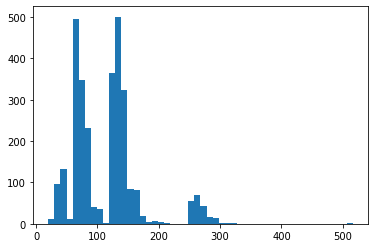

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline
# plt.hist(rewards, bins=50)
# plt.hist(steps, bins=50)
# plt.hist(total_rewards, bins=50)
plt.hist(max_rewards, bins=50)